# Exploring and Evaluating the 2023 Global Firepower Dataset

#### Project Aims:

- Employing effective visualization methods for improving the data's interperability
- Highlighting key trends trends in the dataset to inform future efforts related to:
	- Developing Public Military Data Collection, Feature Engineering, and Analysis
	- Presentation of the global military landscape to non-experts
	- Using the dataset as a learning tool for statistics and data science

## Dataset Overview and Preparation

### About the 2023 GFP Dataset

Based on publicly available data scraped from the [Global Firepower (GFP) website](https://www.globalfirepower.com/), our dataset provides a detailed ranking of military capabilities across 145 countries. Widely referenced in online articles on public perception of military capability, it includes data on defense budgets, personnel numbers (active, reserve, and paramilitary), and equipment inventories like tanks, aircraft, and naval vessels. Additionally, the dataset covers infrastructure aspects such as transportation networks and geographic information. Economic indicators such as Purchasing Power Parity (PPP), oil production and consumption, and external debt are also featured, offering a broader view of each nation's military capacity and preparedness. Based on the website's description, this data aims to aid understanding the balance of power globally. A description of the 58 features in the dataset can be found in the [GFP 2023 Military Dataset Breakdown](https://github.com/elsayedhazem/gfp_data_analysis/blob/main/GFP%20Military%20Dataset%20Breakdown.pdf)

In [349]:
# Run this cell to install the necessary packages
#!conda install pandas numpy matplotlib seaborn plotly nbformat graphviz pydot
#!pip install plotly
#!pip install nbformat

In [350]:
import pandas as pd

df = pd.read_csv('data/clean.csv', index_col=0)
df.shape

(145, 58)

In [351]:
df.head(5).astype(str).T.head(5)

,afghanistan,albania,algeria,angola,argentina
power_index,2.3118,1.8466,0.3911,0.8732,0.4243
ppp,18000000000,38000000000,470000000000,205700000000,900000000000
forex_gold,5000000000,4000000000,100000000000,16995000000,45000000000
defense_budget,49525000,192400000,9979200000,1059270000,3064800000
external_debt,145000000,10000000000,6000000000,45000000000,280000000000


In [390]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, afghanistan to zimbabwe
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ppp                        145 non-null    int64  
 1   forex_gold                 145 non-null    int64  
 2   defense_budget             145 non-null    int64  
 3   external_debt              145 non-null    int64  
 4   square_land_area           145 non-null    int64  
 5   coastline_coverage         145 non-null    int64  
 6   shared_borders             145 non-null    int64  
 7   waterways                  145 non-null    int64  
 8   population                 145 non-null    int64  
 9   available_manpower         145 non-null    int64  
 10  fit_for_service            145 non-null    int64  
 11  reaching_mil_age_annually  145 non-null    int64  
 12  total_personnel            145 non-null    int64  
 13  active_personnel           145 non-null 

 ##### The power feature
 We take the inverse of the power_index column into a power column so stronger militaries have a larger value associated with them. This simplifies the task of interpreting the dataset and does not pose a risk since we will not train a model for the purpose of prediction on unseen data.

In [352]:
df["power"] = df["power_index"] ** -1
df.drop(columns=["power_index"], inplace=True)

#### Partitioning the dataset

In [353]:
# Simplifies visualization
df["country"] = df.index

In [354]:
super_countries = ["united-states-of-america", "china", "russia"]
without_super = df.drop(super_countries, axis=0)

## Visualizing Global Powers: a highly skewed distribution

### Top Powers

In [355]:
import seaborn as sns

def rank(feature, top_n, transform = False):
	df_copy = df.copy()
	if transform:
		df_copy[feature] = np.log(df_copy[feature])
	sns.set(rc={'figure.figsize': (12, 10)})
	sns.barplot(x=feature, y='country', data=df_copy.sort_values(by=feature, ascending=False).head(top_n), hue=feature)

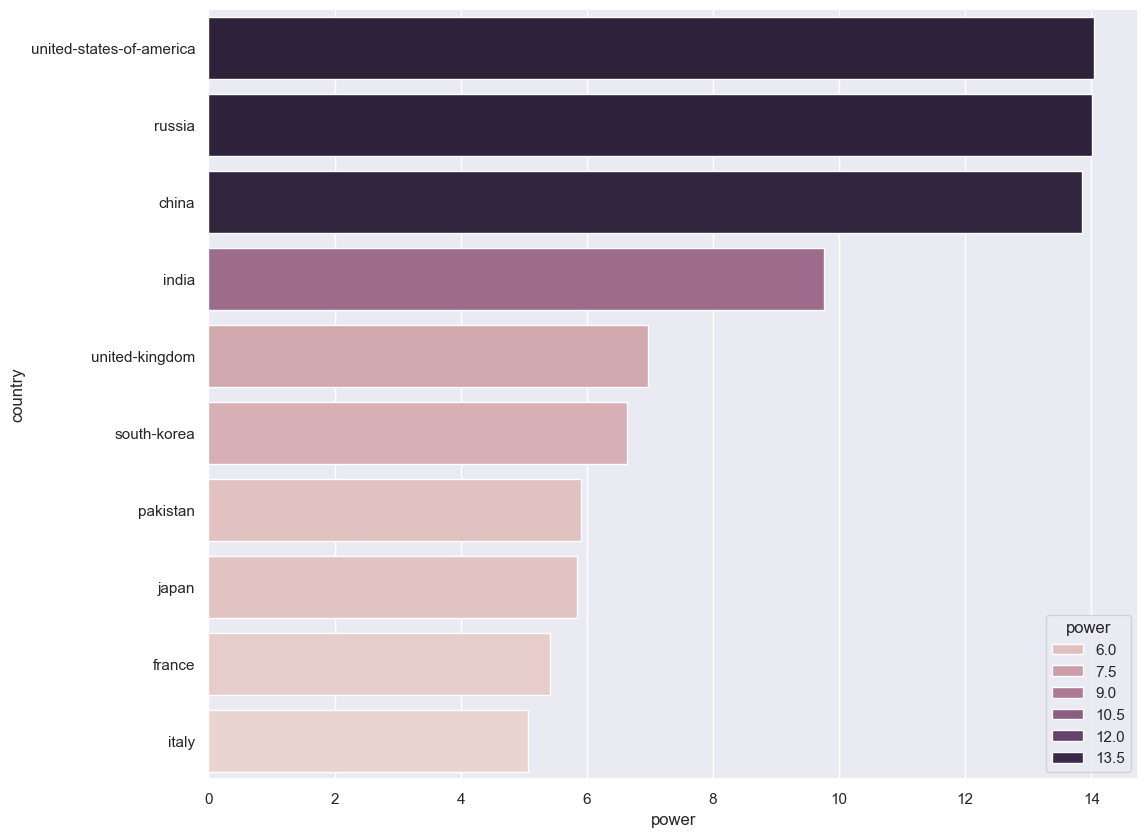

In [356]:
rank("power", 10)

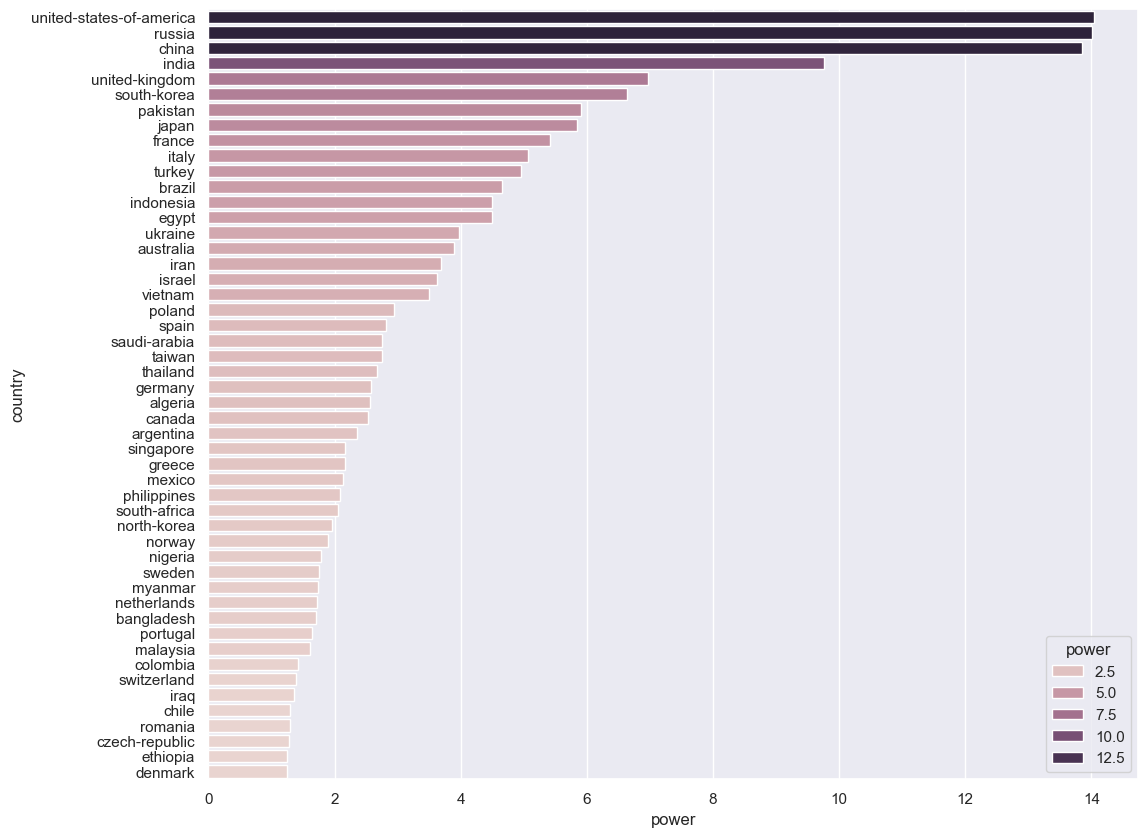

In [357]:
rank("power", 50)

#### On the Map

In [391]:
import plotly.express as px

fig = px.choropleth(
	df,
	locations='country',
	locationmode='country names',
	color='power',
    color_continuous_scale='ylorbr',
	hover_name='country',
	projection='natural earth',

)

fig.update_layout(
	title=f'Power by Country',
	geo=dict(showframe=False, showcoastlines=False,
          projection_type='equirectangular'),
	coloraxis_colorbar=dict(title='Power')
)

fig.show()

### Ranking Countries by Feature

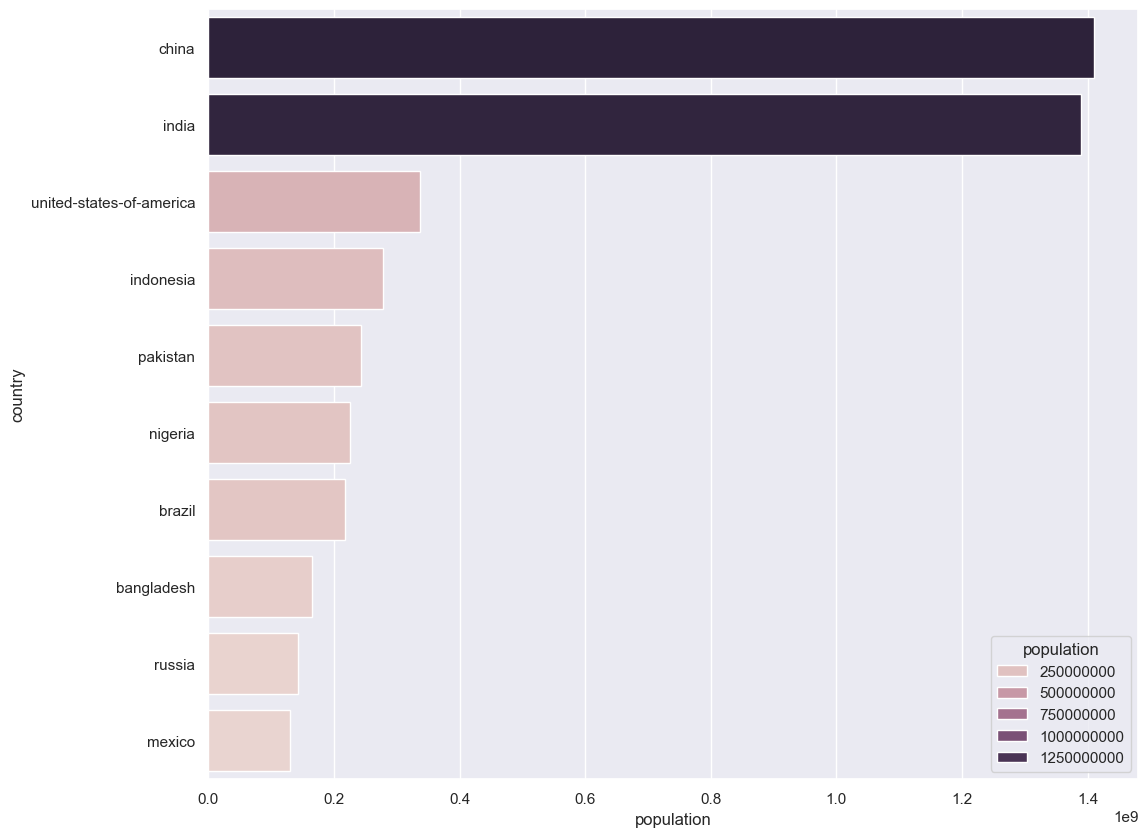

In [359]:
# change feature or top_n to see different results
rank(feature="population", top_n=10, transform=False)

Standardization Function:

In [360]:
def standardize(series):
    if series.dtype == 'object':
        return series

    return (series - series.min()) / (series.max() - series.min())


# standardized copy
df_standardized = df.apply(standardize)
without_super_standardized = without_super.apply(standardize)

### Divisions across countries

In [361]:
# set the countries to compare
countries = ["united-states-of-america", "china", "russia"]

Helper Function

In [362]:
division_columns = {
	'army': ['tanks', 'mlrs', 'artillery', 'vehicles', 'army_personnel'],
	'navy': ['total_naval_assets', 'submarines', 'aircraft_carriers', 'navy_personnel'],
	'air': ['aircraft_total', 'air_force_personnel']
}

def plot_division(countries, division):	
	countries_df_standardized = df_standardized.loc[countries][division_columns[division] + ["country"]]
	df_long = countries_df_standardized.melt(id_vars='country', var_name='force', value_name='value')
	sns.barplot(x='force', y='value', hue='country',
				palette="rocket", data=df_long).set_title(f"{division} forces by country")

### Army

,united-states-of-america,china,russia
tanks,5500,4950,12566
mlrs,1716,3145,3887
artillery,2339,4229,10911
vehicles,303553,174300,151641
army_personnel,1010500,2545000,360000


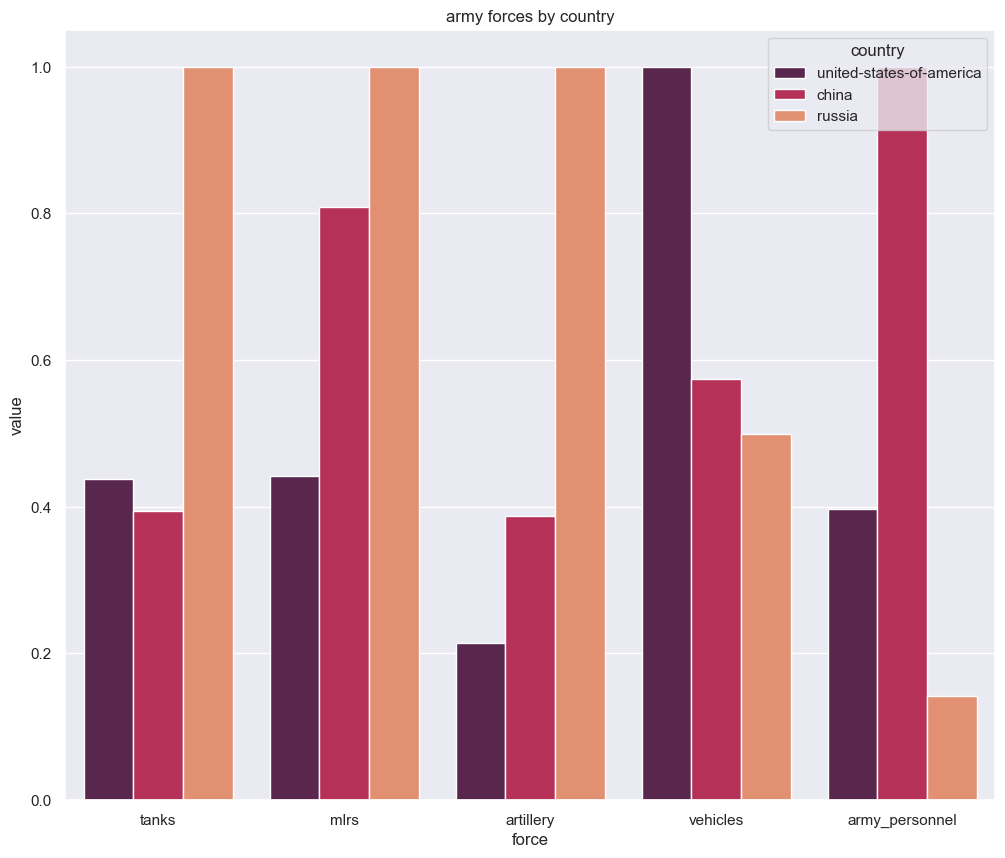

In [363]:
division = 'army'
plot_division(countries, division)
df.loc[countries][division_columns[division]].T

#### Air Force

,united-states-of-america,china,russia
aircraft_total,13300,3166,4182
air_force_personnel,660107,400000,250000


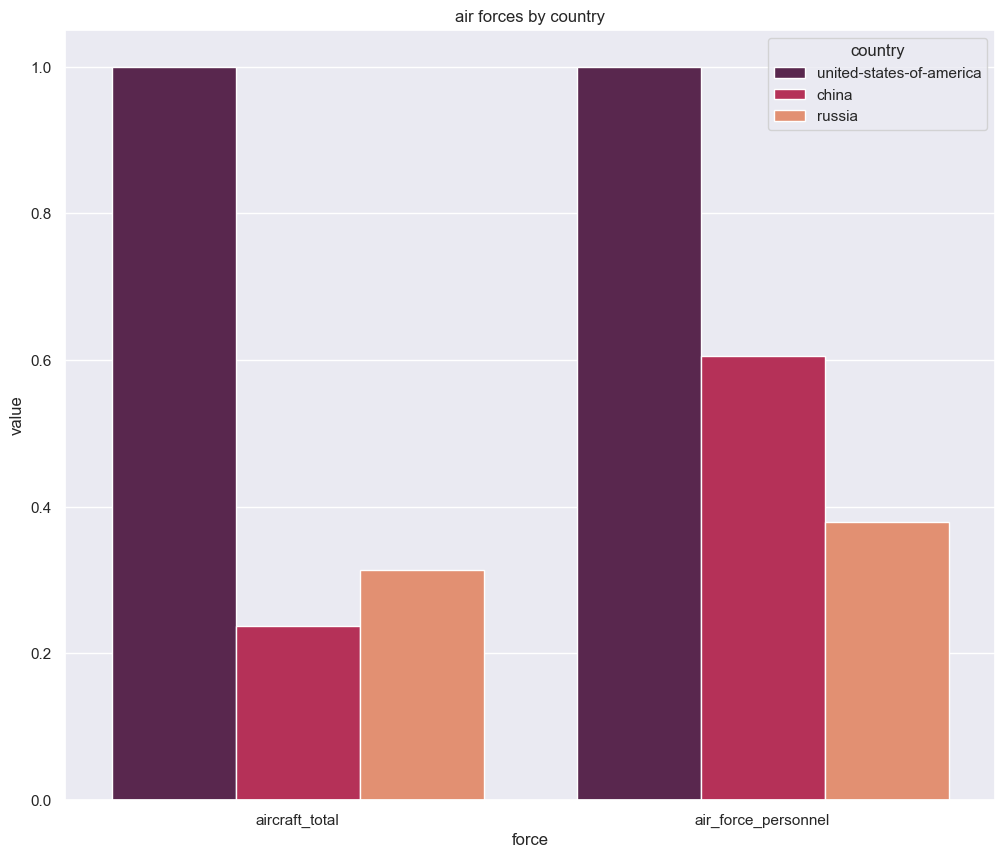

In [364]:
division = 'air'
plot_division(countries, division)
df.loc[countries][division_columns[division]].T

#### Navy

,united-states-of-america,china,russia
total_naval_assets,484.0,730.0,598.0
submarines,68.0,78.0,70.0
aircraft_carriers,11.0,2.0,1.0
navy_personnel,731600.0,300000.0,155000.0


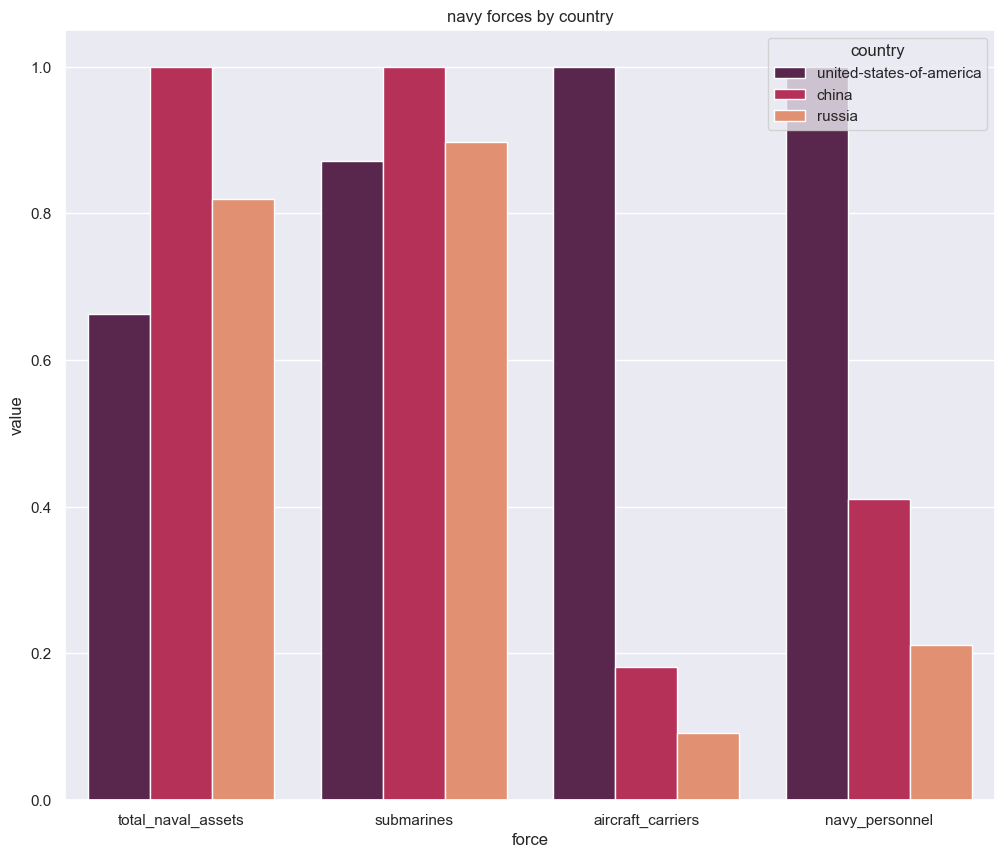

In [365]:
division = 'navy'
plot_division(countries, division)
df.loc[countries][division_columns[division]].T

A better helper function

In [366]:
def compare_countries(countries, columns, title_keyword="Key Metrics", standardized=True):
	if len(countries) > 4:
		raise ValueError("Too many countries to compare. Please select 3 or less.")
	
	if len(columns) > 4:
		raise ValueError("Too many columns to compare. Please select 3 or less.")

	plot_df = df_standardized if standardized else df
	plot_df = plot_df.loc[countries][columns + ["country"]]
	df_long = plot_df[columns + ['country']
                                   ].melt(id_vars='country', var_name='metric', value_name='value')
	sns.barplot(x='metric', y='value', hue='country',
             palette="rocket", data=df_long).set_title(f"{title_keyword} by country")

### Comparing Countries Accross Features

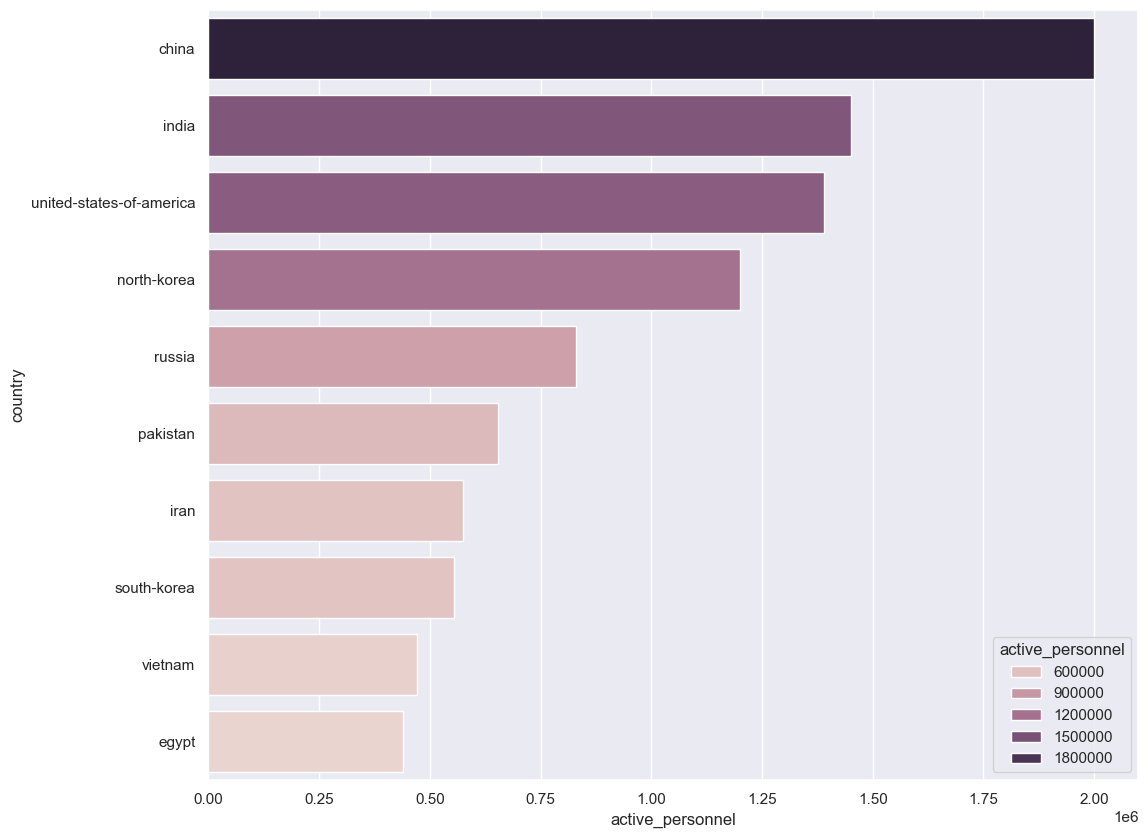

In [367]:
rank("active_personnel", 10, transform=False)

## Feature Analysis and RF Modeling

### First Glance: Correlations

Due to skewness and small sample size, we use kendall's tau to interpret associations between variables

In [368]:
corr = df.drop(columns=["lat", "long", "country"], axis=1).corr(method='kendall')

<Axes: >

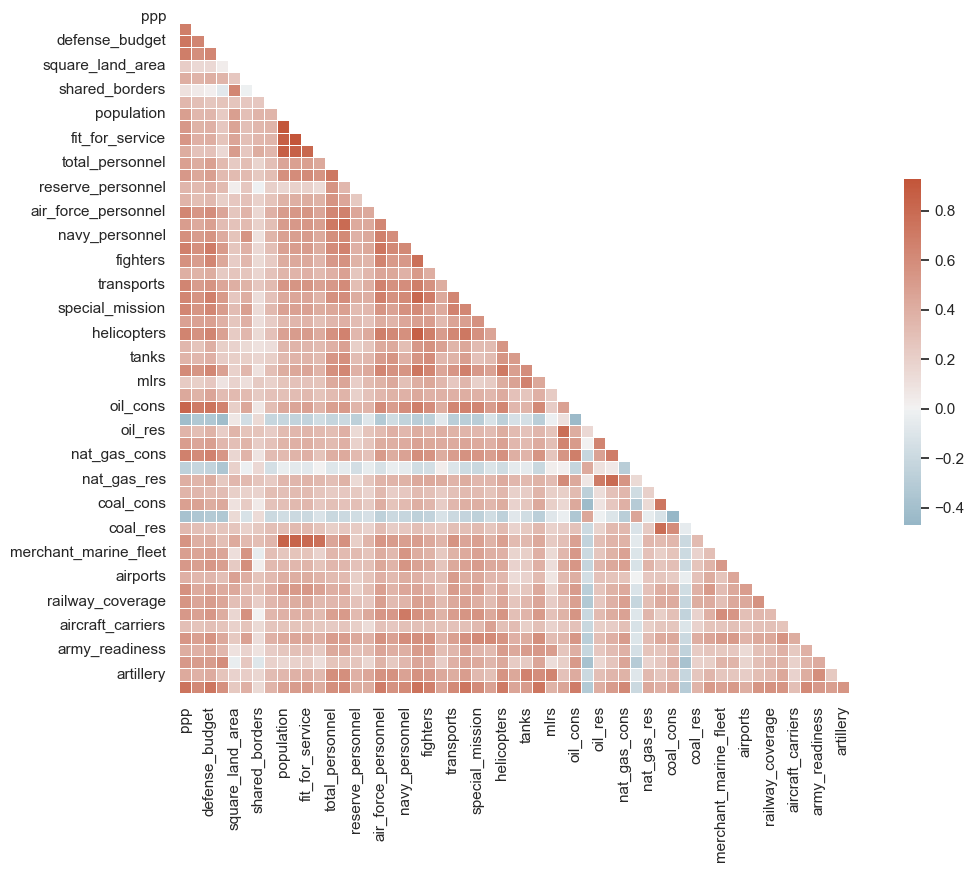

In [369]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="white")

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

# a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=0.6, cbar_kws={"shrink": .5})

Helper Functions

In [370]:
def top_correlations(feature, include_super=False):
	thedf = df if include_super else without_super
	corr = thedf.drop(columns=["lat", "long", "country"],
	                  axis=1).corr(method="kendall")
	corr = corr[feature].sort_values(ascending=False)[1:].head(10)
	return corr


def correlation(feature_a, feature_b, include_super=False):
	thedf = df if include_super else without_super
	corr = thedf.drop(columns=["lat", "long", "country"],
	                  axis=1).corr(method="kendall")
	return corr[feature_a][feature_b]

### Which features are closely correlated with Power?

In [371]:
top_correlations("power", include_super=True)

aircraft_total         0.753002
ppp                    0.742797
vehicles               0.728927
defense_budget         0.728866
trainers               0.722585
helicopters            0.705761
oil_cons               0.692383
air_force_personnel    0.690335
fighters               0.669764
nat_gas_cons           0.621711
Name: power, dtype: float64

In [372]:
power_corr_negative = corr[corr['power'] < 0]['power'].sort_values(ascending=True)
power_corr_negative.head(10)

oil_deficit       -0.321097
coal_deficit      -0.299452
nat_gas_deficit   -0.192667
Name: power, dtype: float64

Excluding top countries when calculating kendall's correlation coefficient, which accounts for the skewness in our data, does not have a significant impact on results:

In [373]:
# Difference between spearman correlation with and without super countries
top_correlations("power", include_super=False)

aircraft_total         0.742393
ppp                    0.732764
vehicles               0.717511
defense_budget         0.717447
trainers               0.711020
helicopters            0.693086
oil_cons               0.679777
air_force_personnel    0.677347
fighters               0.654863
forex_gold             0.609291
Name: power, dtype: float64

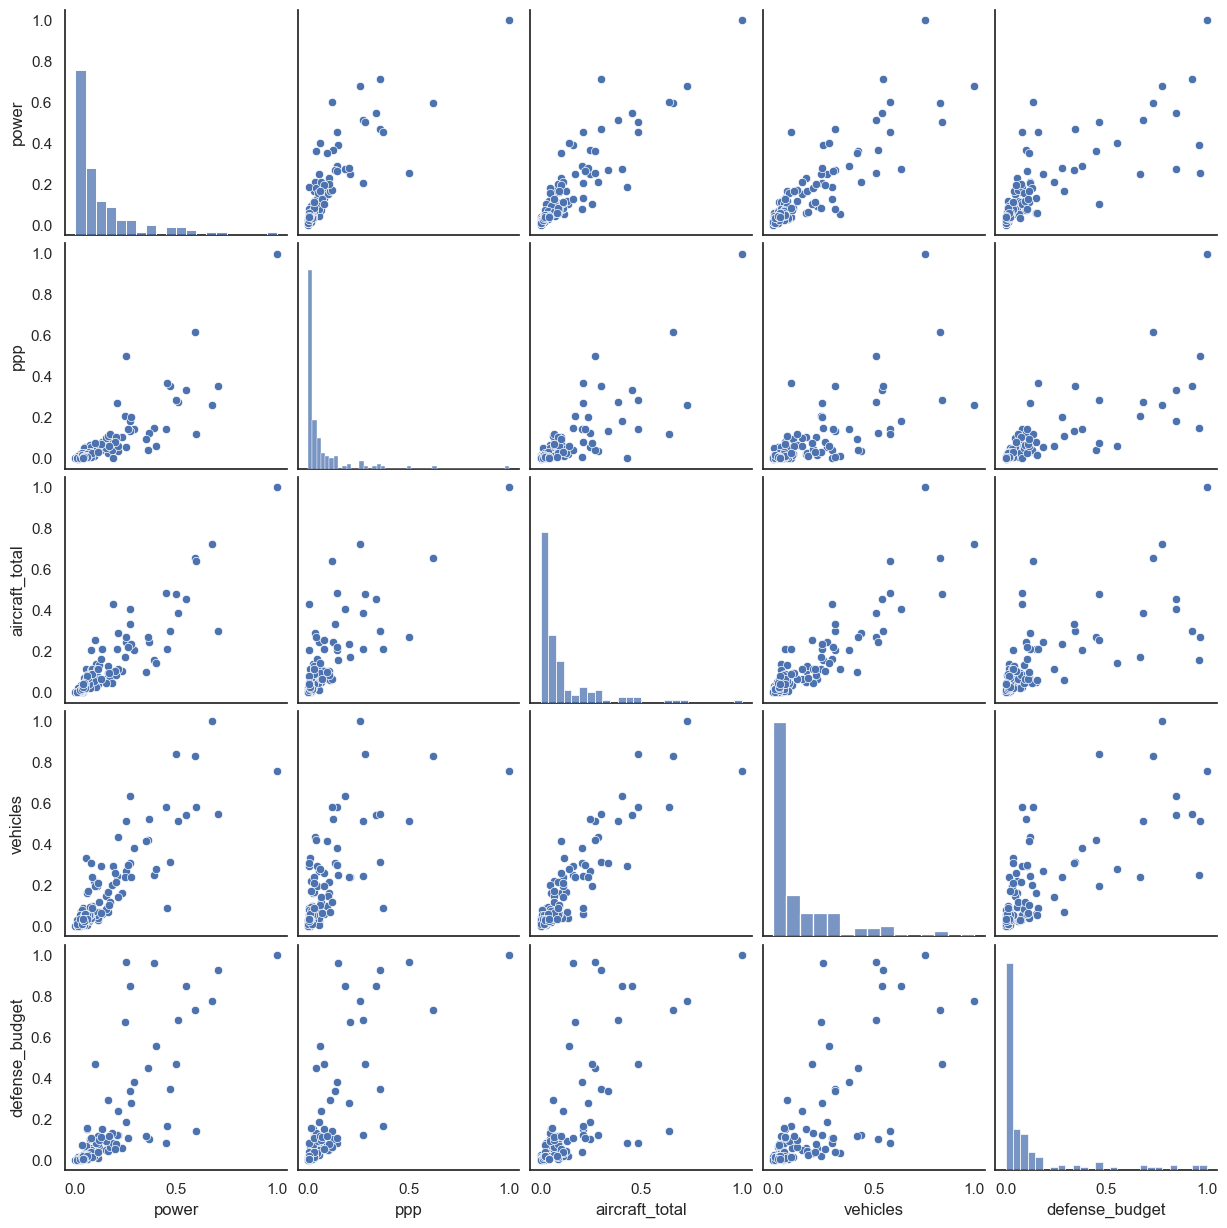

In [374]:
sns.pairplot(without_super_standardized[['power', 'ppp', 'aircraft_total', 'vehicles', 'defense_budget']])

### Random Forests

Helper Functions

In [375]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot


def build_rf(transform_labels=False, include_super=True):
	thedf = df if include_super else without_super
	
	labels = thedf['power'].to_numpy()
	features = thedf.drop(columns=['power', 'country', 'lat', 'long'], axis=1)
	features_list = features.columns.tolist()

	if transform_labels:
		labels = np.log(labels)

	rf = RandomForestRegressor(n_estimators=100, max_depth=None, bootstrap=False)
	rf.fit(features, labels)

	file_string = 'tree' if include_super else 'tree_without_super'
	file_string = file_string + '_transformed' if transform_labels else file_string
	file_string = 'images/' + file_string
	
	visualize_tree(rf, features_list, output_file_labels=file_string)
	show_importances(rf, features_list)


def visualize_tree(rf, feature_names, output_file_labels='tree'):
	estimator = rf.estimators_[5]
	export_graphviz(estimator, out_file=f'{output_file_labels}.dot',
                 feature_names=feature_names,
                 rounded=True, proportion=False,
                 precision=2, filled=True)

	(graph, ) = pydot.graph_from_dot_file(f'{output_file_labels}.dot')
	graph.write_png(f'{output_file_labels}.png')


def show_importances(rf, features_list):
	importances = list(rf.feature_importances_)

	# List of tuples with variable and importance
	feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list, importances)]

	# Sort the feature importances by most important first
	feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

	count = 10
	for pair in feature_importances:
		print('Variable: {:20} Importance: {}'.format(*pair))
		count -=1
		if count == 0:
			break

##### First Fit

In [376]:
build_rf()

Variable: trainers             Importance: 0.64
Variable: navy_personnel       Importance: 0.11
Variable: square_land_area     Importance: 0.04
Variable: roadway_coverage     Importance: 0.04
Variable: defense_budget       Importance: 0.03
Variable: labor_force          Importance: 0.03
Variable: total_naval_assets   Importance: 0.03
Variable: air_force_personnel  Importance: 0.02
Variable: ppp                  Importance: 0.01
Variable: vehicles             Importance: 0.01


##### After log-transforming labels

In [377]:
build_rf(transform_labels=True)

Variable: ppp                  Importance: 0.78
Variable: aircraft_total       Importance: 0.08
Variable: vehicles             Importance: 0.03
Variable: transports           Importance: 0.02
Variable: tanks                Importance: 0.02
Variable: defense_budget       Importance: 0.01
Variable: oil_prod             Importance: 0.01
Variable: roadway_coverage     Importance: 0.01
Variable: submarines           Importance: 0.01
Variable: artillery            Importance: 0.01


##### After removing outliers and log-transforming labels

In [378]:
build_rf(include_super=False, transform_labels=True)

Variable: ppp                  Importance: 0.77
Variable: aircraft_total       Importance: 0.09
Variable: vehicles             Importance: 0.03
Variable: tanks                Importance: 0.02
Variable: submarines           Importance: 0.02
Variable: defense_budget       Importance: 0.01
Variable: oil_prod             Importance: 0.01
Variable: roadway_coverage     Importance: 0.01
Variable: artillery            Importance: 0.01
Variable: forex_gold           Importance: 0.0


- Correlations are all close to 0.7-0.75, and features exist in clusters of high correlation
- RF used PPP significantly in its nodes to narrow down samples, then aircraft total and to a lesser degree budgets
- Manpower and Geographic features have not been used significantly by the trees to seperate between data.

### Principal Component Analysis

In [379]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def get_pca(include_super=True, n_components=4):
	scaler = StandardScaler()

	if not include_super:
		X = without_super.drop(columns=["country", "lat", "long", "power"], axis=1)
	else:
		X = df.drop(columns=["country", "lat", "long", "power"], axis=1)
	
	X_scaled = scaler.fit_transform(np.array(X, dtype=float))

	pca = PCA(n_components=4)
	X_pca = pca.fit_transform(X_scaled)
	print("original shape:   ", X.shape)
	print("transformed shape:", X_pca.shape)

	print("Cumulative explained variance:", pca.explained_variance_ratio_.sum().round(2))
	[print(f"PC{i + 1}: {round(pca.explained_variance_ratio_[i], 2)}") for i in range(4)]
	return pca

In [380]:
pca = get_pca(include_super=True)

original shape:    (145, 55)
transformed shape: (145, 4)
Cumulative explained variance: 0.78
PC1: 0.52
PC2: 0.14
PC3: 0.08
PC4: 0.04


In [381]:
pca_without_super = get_pca(include_super=False)

original shape:    (142, 55)
transformed shape: (142, 4)
Cumulative explained variance: 0.67
PC1: 0.41
PC2: 0.1
PC3: 0.09
PC4: 0.07


In [382]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

features = range(pca.n_components_)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_without_super = pca_without_super.components_.T * np.sqrt(pca_without_super.explained_variance_)

columns = df.drop(columns=["country", "lat", "long", "power"], axis=1).columns

df_loadings = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in features], index=columns)
df_loadings_without_super = pd.DataFrame(loadins_without_super, columns=[f'PC{i+1}' for i in features], index=columns)

PC1 With Super Powers

In [383]:
df_loadings.PC1.sort_values(ascending=False).head(10)

air_force_personnel    0.982454
fighters               0.966894
oil_cons               0.957450
navy_personnel         0.946298
transports             0.941484
railway_coverage       0.937410
ppp                    0.933524
roadway_coverage       0.926758
aircraft_total         0.921068
nat_gas_cons           0.914809
Name: PC1, dtype: float64

PC1 Without Super Powers

In [384]:
df_loadings_without_super.PC1.sort_values(ascending=False).head(10)

aircraft_total         0.927990
air_force_personnel    0.916113
ppp                    0.913060
transports             0.890648
helicopters            0.883134
navy_personnel         0.882383
oil_cons               0.866231
active_personnel       0.853440
roadway_coverage       0.836541
army_personnel         0.830268
Name: PC1, dtype: float64

PC2

In [385]:
df_loadings.PC2.sort_values(ascending=False).head(10)

fit_for_service              0.686475
available_manpower           0.686143
labor_force                  0.684295
reaching_mil_age_annually    0.669070
population                   0.664205
coal_cons                    0.647964
coal_prod                    0.607019
forex_gold                   0.594219
army_personnel               0.559418
total_personnel              0.412825
Name: PC2, dtype: float64

PC2 - Without Super Powers

In [386]:
df_loadings_without_super.PC2.sort_values(ascending=False).head(10)

reaching_mil_age_annually    0.485497
population                   0.453508
available_manpower           0.447565
fit_for_service              0.438699
labor_force                  0.432951
coal_cons                    0.378089
army_personnel               0.357053
total_personnel              0.326257
paramilitary                 0.293231
coal_prod                    0.280151
Name: PC2, dtype: float64

PC3

In [387]:
df_loadings.PC3.sort_values(ascending=False).head(10)

nat_gas_res         0.683795
oil_deficit         0.640827
nat_gas_deficit     0.587607
tanks               0.558398
artillery           0.544206
mlrs                0.499843
square_land_area    0.442525
oil_res             0.381162
waterways           0.361320
shared_borders      0.351135
Name: PC3, dtype: float64

### Interpretation of PCA and Modeling Results

 The cumulative variance after 4 principal components can be seen as reasonable given the small size of our dataset.
 
 PC1 can be interpreted as representative of the military infrastructure and the scale of military operations, with a focus on air and naval power, as well as economic capacity of the country. Most of the loadings follow each other closely and are highly correlated. PC2 explains some variance in our data as well, primarily representing human resources which were not seen as significant by the RF model. However, from PC3 onwards, the relationships between the features seem to be difficult to define.

 We can thus reach a few reasonable hypotheses which can be further developed:

 - That human resources in general are a secondary factor in the GFP measure of power, superceded by financial backing
 - Geographic Markers do not contribute significantly to the variance in the dataset
 - The size of the dataset limits more detailed patterns between variables

In [388]:
def compare_coalitions(countries_a, countires_b, columns, title_keyword="Key Metrics", standardized=True):
	if len(columns) > 5:
		raise ValueError("Too many columns to compare. Please select 3 or less.")

	plot_df = df_standardized if standardized else df

	coalition_series_a = plot_df.loc[countries_a].sum()
	coalition_series_a["country"] = "Coalition A"

	if standardized:
		coalition_series_a['ppp'] = coalition_series_a['ppp'] / len(countries_a)
	else:
		coalition_series_a['ppp'] = coalition_series_a['ppp'] // len(countries_a)

	coalition_series_a['airforce_readiness'] = coalition_series_a['airforce_readiness'] / \
		len(countries_a)
	coalition_series_a['army_readiness'] = coalition_series_a['army_readiness'] / \
		len(countries_a)

	coalition_series_b = plot_df.loc[countries_b].sum()
	coalition_series_b["country"] = "Coalition B"
	if standardized:
		coalition_series_b['ppp'] = coalition_series_b['ppp'] / len(countries_b)
	else:
		coalition_series_b['ppp'] = coalition_series_b['ppp'] // len(countries_b)

	coalition_series_b['airforce_readiness'] = coalition_series_b['airforce_readiness'] / \
		len(countries_b)
	coalition_series_b['army_readiness'] = coalition_series_b['army_readiness'] / \
		len(countries_b)

	coalition_df = pd.concat([coalition_series_a, coalition_series_b], axis=1).T

	coalition_df = coalition_df[columns + ["country"]]
	df_long = coalition_df[columns + ['country']
                        ].melt(id_vars='country', var_name='metric', value_name='value')
	sns.barplot(x='metric', y='value', hue='country',
             palette="rocket", data=df_long).set_title(f"{title_keyword} by Coalition")
	return coalition_df

## Findings

**The lack of distinctive patterns in feature columns undermines the reliability GFP measure of Power**

Upon analysis, the GFP measure of military power is not clearly reproducible by the data and annotations provided on the website.

**Inaccurate, Incomplete Data Points further complicate a small sample**

There is no clear way to verify the accuracy of the data on the GFP website - which remains the most popular source for global military data. This inherently limits the reliability of any findings based on this type of data which can perceived is theoratically informative.

**Feature Engineering and Supplementing the dataset for unveiling new Patterns**

To address the limitations of the current dataset, feature engineering and data supplementation could be instrumental. Incorporating additional variables such as technological advancement indexes, geopolitical stability scores, combat experience measures, and aliance information, can lead to a more nuanced analysis of military capability, and coupling the dataset with other datasets from adjacent fields like industry and employment can aid further research.

**Studying the global landscape over time**


A promising future contribution is developing a more comprehensive, longitudinal dataset for analyzing global military data over time. Given that military capabilities evolve with technological advancements, political changes, and economic developments. Tracking these changes over time can reveal trends and patterns in military development and strategic positioning as well as their impacts. This longitudinal analysis could be particularly revealing in understanding how emerging technologies or global events impact military strength and geopolitical dynamics. It would also allow for the assessment of how consistent the GFP rankings are over time and whether certain countries are consistently overrated or underrated in their military capabilities.

## Exploration: Comparing Coalitions

In [389]:
columns = ["fit_for_service", "total_naval_assets", "aircraft_total", "vehicles", "reserve_personnel"]
countries_a = []
countries_b = []
compare_coalitions(countries_a, countries_b, columns,
                   "Military Capability", standardized=True)